In [2]:
import json
import sys
import random
from tqdm import tqdm
from collections import defaultdict
import pyarrow as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%time
root = '.'

train_data = list(
    map(json.loads, open(f"{root}/cosmos/train_data.json").readlines())
)
test_data = list(
    map(json.loads, open(f"{root}/cosmos/test_data.json").readlines())
)
val_data = list(map(json.loads, open(f"{root}/cosmos/val_data.json").readlines()))

CPU times: user 11.2 s, sys: 680 ms, total: 11.9 s
Wall time: 11.9 s


In [3]:
splits = [
    "train",
    "test",
    "val",
]
datas = [
    train_data,
    test_data,
    val_data,
]

100%|████████████| 161754/161754 [00:00<00:00, 757833.85it/s]


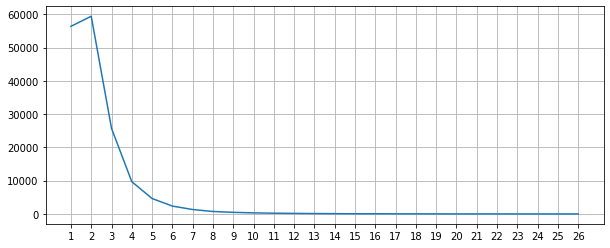

In [4]:
# Articles count
article_count = defaultdict(int)
for data in tqdm(train_data):
    n_article = len(data['articles'])
    article_count[n_article] += 1
    
lists = sorted(article_count.items())
x, y = zip(*lists)
plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.grid()
plt.show()

In [15]:
train_data

[{'img_local_path': 'train/1.jpg',
  'articles': [{'caption': 'The technical infrastructure of WhatsApp, Instagram and Facebook Messenger will be unified.',
    'article_url': 'https://www.nytimes.com/2019/01/25/technology/facebook-instagram-whatsapp-messenger.html',
    'caption_modified': 'The technical infrastructure of ORG, PRODUCT and PERSON will be unified.',
    'entity_list': [['WhatsApp', 'ORG'],
     ['Instagram', 'PRODUCT'],
     ['Facebook Messenger', 'PERSON']]},
   {'caption': 'This photo taken March 22, 2018, shows apps for WhatsApp, Facebook, Instagram and other social networks on a smartphone.',
    'article_url': 'https://citizentv.co.ke/business/how-to-share-your-whatsapp-status-on-facebook-283645/',
    'caption_modified': 'This photo taken DATE, shows apps for ORG, ORG, PRODUCT and other social networks on a smartphone.',
    'entity_list': [['March 22, 2018', 'DATE'],
     ['WhatsApp', 'ORG'],
     ['Facebook', 'ORG'],
     ['Instagram', 'PRODUCT']]},
   {'caption

In [55]:
# np.random.seed(42)
train_data_sample = np.random.choice(train_data, size=int(len(train_data)*50/100))
# train_data_sample=train_data[:1]
# Not OOC cases
l = []
for data in tqdm(train_data_sample):
    if len(data['articles']) > 1:
        # Pick 2 random caption
        caption_1_idx, caption_2_idx = random.sample(range(0,len(data['articles'])),2)
        cap1 = data['articles'][caption_1_idx]['caption_modified']
        cap2 = data['articles'][caption_2_idx]['caption_modified']
        l.append([data['img_local_path'],[cap1],[cap2],[False]])
    if len(data['articles']) == 1 or np.random.rand() > 0.6:
        if np.random.rand()>0.6:
            data_random1 = train_data[np.random.randint(len(train_data))]
            while data['img_local_path'] == data_random1['img_local_path']:
                data_random1 = train_data[np.random.randint(len(train_data))]
            cap1 = data_random1['articles'][np.random.randint(len(data_random1['articles']))]['caption_modified']
            data_random2 = train_data[np.random.randint(len(train_data))]
            while data['img_local_path'] == data_random2['img_local_path']:
                data_random2 = train_data[np.random.randint(len(train_data))]
            cap2 = data_random2['articles'][np.random.randint(len(data_random2['articles']))]['caption_modified']
        else:
             # Pick 1st correct caption
            if np.random.rand()>0.5:
                cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
                # Pick a random article then pick its first caption
                data_random = train_data[np.random.randint(len(train_data))]
                while data['img_local_path'] == data_random['img_local_path']:
                    data_random = train_data[np.random.randint(len(train_data))]
                cap2 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
            else:
                cap2 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
                # Pick a random article then pick its first caption
                data_random = train_data[np.random.randint(len(train_data))]
                if data['img_local_path'] == data_random['img_local_path']:
                    continue
                cap1 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
        l.append([data['img_local_path'],[cap1],[cap2],[True]])

100%|██████████| 80877/80877 [00:01<00:00, 76090.69it/s]


In [56]:
l

[['train/90380.jpg',
  ['Patient PERSON, who was injured during recent shelling, receives medical assistance in a hospital in GPE in the course of a military conflict over the breakaway region of LOC, DATE.'],
  ['Patient PERSON, who was injured during recent shelling, receives medical assistance in a hospital in GPE in the course of a military conflict over the breakaway region of LOC, DATE.'],
  [False]],
 ['train/90380.jpg',
  ['Trucks are parked in front of GPE FAC to provide a protective barrier for President-elect PERSON on DATE.'],
  ['Patient PERSON, who was injured during recent shelling, receives medical assistance in a hospital in GPE in the course of a military conflict over the breakaway region of LOC, DATE.'],
  [True]],
 ['train/101313.jpg',
  ['NORP presidential nominee Senator PERSON and his wife PERSON prepare to cast their votes in the presidential election as their daughters GPE (L) and PERSON look on, at FAC in GPE, DATE.'],
  ['NORP presidential nominee Senator PE

In [57]:
dataframe = pd.DataFrame(
    l, columns=["image", "caption_1", "caption_2", "label"],
)

In [58]:
dataframe

,image,caption_1,caption_2,label
0,train/90380.jpg,"[Patient PERSON, who was injured during recent...","[Patient PERSON, who was injured during recent...",[False]
1,train/90380.jpg,[Trucks are parked in front of GPE FAC to prov...,"[Patient PERSON, who was injured during recent...",[True]
2,train/101313.jpg,[NORP presidential nominee Senator PERSON and ...,[NORP presidential nominee Senator PERSON and ...,[False]
3,train/101313.jpg,[NORP presidential nominee Senator PERSON and ...,[Mr. PERSON speaking about the public health r...,[True]
4,train/72846.jpg,[Dancers appear in silhouette during rehearsal...,"[PERSON, a NORP, in GPE in DATE. She and her N...",[True]
...,...,...,...,...
102184,train/79061.jpg,[This photo taken on DATE shows an aerial shot...,[How should you improvise when a new employer ...,[True]
102185,train/159178.jpg,"[Slideboarding - Great Wolf Lodge PERSON, ORG]",[Slideboarding rafts at FAC in the ORG double ...,[False]
102186,train/24212.jpg,"[CARDINAL stretch of ORG, which runs through a...",[ORG: Many of those injured in the March of Re...,[True]
102187,train/120353.jpg,[CARDINAL GPE melanogaster fruit flies enginee...,"[\nGPE by GPE, a Factory-Made Answer for a Hou...",[True]


In [59]:
def load_image(path):
   try:
      with open(path, "rb") as fp:
        return fp.read()
   except:
      return None

In [60]:
tqdm.pandas()

dataframe['image'] = dataframe['image'].progress_apply(lambda x: load_image(x))

/root/anaconda3/envs/vilt/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 102189/102189 [00:07<00:00, 14345.45it/s]


In [61]:
dataframe = dataframe[dataframe.image.notnull()]

In [62]:
dataframe

,image,caption_1,caption_2,label
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[Patient PERSON, who was injured during recent...","[Patient PERSON, who was injured during recent...",[False]
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Trucks are parked in front of GPE FAC to prov...,"[Patient PERSON, who was injured during recent...",[True]
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[NORP presidential nominee Senator PERSON and ...,[NORP presidential nominee Senator PERSON and ...,[False]
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[NORP presidential nominee Senator PERSON and ...,[Mr. PERSON speaking about the public health r...,[True]
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Dancers appear in silhouette during rehearsal...,"[PERSON, a NORP, in GPE in DATE. She and her N...",[True]
...,...,...,...,...
102184,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[This photo taken on DATE shows an aerial shot...,[How should you improvise when a new employer ...,[True]
102185,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[Slideboarding - Great Wolf Lodge PERSON, ORG]",[Slideboarding rafts at FAC in the ORG double ...,[False]
102186,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[CARDINAL stretch of ORG, which runs through a...",[ORG: Many of those injured in the March of Re...,[True]
102187,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[CARDINAL GPE melanogaster fruit flies enginee...,"[\nGPE by GPE, a Factory-Made Answer for a Hou...",[True]


# PyArrow

In [63]:
table = pa.Table.from_pandas(dataframe)


In [64]:
split = 'train'
with pa.OSFile(f"dataset_50/cosmos_{split}.arrow", "wb") as sink:
    with pa.RecordBatchFileWriter(sink, table.schema) as writer:
        writer.write_table(table)

# Val

In [65]:
# np.random.seed(42)
val_data_sample = np.random.choice(val_data, size=int(len(val_data)*50/100))
# train_data_sample=train_data[:1]
# Not OOC cases
l = []
for data in tqdm(val_data_sample):
    if len(data['articles']) > 1:
        # Pick 2 random caption
        caption_1_idx, caption_2_idx = random.sample(range(0,len(data['articles'])),2)
        cap1 = data['articles'][caption_1_idx]['caption_modified']
        cap2 = data['articles'][caption_2_idx]['caption_modified']
        l.append([data['img_local_path'],[cap1],[cap2],[False]])
    if len(data['articles']) == 1 or np.random.rand() > 0.6:
        if np.random.rand()>0.6:
            data_random1 = train_data[np.random.randint(len(train_data))]
            while data['img_local_path'] == data_random1['img_local_path']:
                data_random1 = train_data[np.random.randint(len(train_data))]
            cap1 = data_random1['articles'][np.random.randint(len(data_random1['articles']))]['caption_modified']
            data_random2 = train_data[np.random.randint(len(train_data))]
            while data['img_local_path'] == data_random2['img_local_path']:
                data_random2 = train_data[np.random.randint(len(train_data))]
            cap2 = data_random2['articles'][np.random.randint(len(data_random2['articles']))]['caption_modified']
        else:
             # Pick 1st correct caption
            if np.random.rand()>0.5:
                cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
                # Pick a random article then pick its first caption
                data_random = train_data[np.random.randint(len(train_data))]
                while data['img_local_path'] == data_random['img_local_path']:
                    data_random = train_data[np.random.randint(len(train_data))]
                cap2 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
            else:
                cap2 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
                # Pick a random article then pick its first caption
                data_random = train_data[np.random.randint(len(train_data))]
                if data['img_local_path'] == data_random['img_local_path']:
                    continue
                cap1 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
        l.append([data['img_local_path'],[cap1],[cap2],[True]])

100%|██████████| 20503/20503 [00:02<00:00, 9453.45it/s]


In [66]:
dataframe = pd.DataFrame(
    l, columns=["image", "caption_1", "caption_2", "label"],
)

In [67]:
tqdm.pandas()

dataframe['image'] = dataframe['image'].progress_apply(lambda x: load_image(x))
dataframe = dataframe[dataframe.image.notnull()]

/root/anaconda3/envs/vilt/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25638/25638 [00:01<00:00, 15542.73it/s]


In [68]:
table = pa.Table.from_pandas(dataframe)
split = 'val'
with pa.OSFile(f"dataset_50/cosmos_{split}.arrow", "wb") as sink:
    with pa.RecordBatchFileWriter(sink, table.schema) as writer:
        writer.write_table(table)

# Test

In [70]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [71]:
def modify_caption_replace_entities(caption_text):
    """
        Utility function to replace named entities in the caption with their corresponding hypernyms
        Args:
            caption_text (str): Original caption with named entities
        Returns:
            caption_modified (str): Modified caption after replacing named entities
    """
    doc = nlp(caption_text)
    caption_modified = caption_text
    caption_entity_list = []
    for ent in doc.ents:
        caption_entity_list.append((ent.text, ent.label_))
        caption_modified = caption_modified.replace(ent.text, ent.label_, 1)
    return caption_modified

In [72]:
l_test  = []
for data in tqdm(test_data):
    cap1 = modify_caption_replace_entities(data['caption1'])
    cap2 = modify_caption_replace_entities(data['caption2'])
    l_test.append([data['img_local_path'],[cap1],[cap2],[data['context_label']==True]])

100%|██████████| 1700/1700 [00:19<00:00, 88.33it/s]


In [73]:
dataframe_test = pd.DataFrame(
    l_test, columns=["image", "caption_1", "caption_2", "label"],
)

In [74]:
dataframe_test

,image,caption_1,caption_2,label
0,test/0.jpg,"[PERSON at his announcement in GPE, GPE, on DA...","[PERSON at his announcement in GPE, GPE, on DA...",[False]
1,test/1.jpg,[Supporters of GPE's ruling ORG party come out...,[A person sits on a truck as supporters of the...,[False]
2,test/2.jpg,[CARDINAL dead people turned up on the state’s...,[These social media posts did not link to a re...,[True]
3,test/3.jpg,"[Actor, musician, director and devoted followe...",[A shocking report about the former child acto...,[True]
4,test/4.jpg,[Men from the LOC tribe perform a traditional ...,"[And on DATE in GPE's Narok county, young PERS...",[False]
...,...,...,...,...
1695,test/1695.jpg,[President PERSON trademarked the name 'WORK_O...,[There was no truth that PERSON family MONEY w...,[True]
1696,test/1696.jpg,[A photograph shows a soldier carrying a donke...,[Coronavirus meme featuring “EVENT donkey” is ...,[True]
1697,test/1697.jpg,[Homeless people living on streets in GPE],[ORG in GPE],[False]
1698,test/1698.jpg,[The castle's esplanade was a perfect spot for...,[Picture shows an ORG skier],[False]


In [75]:
tqdm.pandas()

dataframe_test['image'] = dataframe_test['image'].progress_apply(lambda x: load_image(x))

/root/anaconda3/envs/vilt/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1700/1700 [00:00<00:00, 9703.16it/s]


In [76]:
dataframe_test

,image,caption_1,caption_2,label
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[PERSON at his announcement in GPE, GPE, on DA...","[PERSON at his announcement in GPE, GPE, on DA...",[False]
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Supporters of GPE's ruling ORG party come out...,[A person sits on a truck as supporters of the...,[False]
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[CARDINAL dead people turned up on the state’s...,[These social media posts did not link to a re...,[True]
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[Actor, musician, director and devoted followe...",[A shocking report about the former child acto...,[True]
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Men from the LOC tribe perform a traditional ...,"[And on DATE in GPE's Narok county, young PERS...",[False]
...,...,...,...,...
1695,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[President PERSON trademarked the name 'WORK_O...,[There was no truth that PERSON family MONEY w...,[True]
1696,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[A photograph shows a soldier carrying a donke...,[Coronavirus meme featuring “EVENT donkey” is ...,[True]
1697,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Homeless people living on streets in GPE],[ORG in GPE],[False]
1698,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[The castle's esplanade was a perfect spot for...,[Picture shows an ORG skier],[False]


# PyArrow

In [77]:
table = pa.Table.from_pandas(dataframe_test)
split = 'test'
with pa.OSFile(f"dataset_50/cosmos_{split}.arrow", "wb") as sink:
    with pa.RecordBatchFileWriter(sink, table.schema) as writer:
        writer.write_table(table)

# Dataset

In [42]:
from vilt.datasets.base_dataset import BaseDataset
class COSMOSDataset(BaseDataset):
    def __init__(self, *args, split="", **kwargs):
        assert split in ["train", "val", "test"]
        self.split = split

        if split == "train":
            names = ["cosmos_train"]
        elif split == "val":
            names = ["cosmos_val", "cosmos_test"]
        elif split == "test":
            names = ["cosmos_val", "cosmos_test"]

        super().__init__(
            *args,
            **kwargs,
            names=names,
            text_column_name="caption_1",
            remove_duplicate=False,
        )
    
    def get_text_2(self, raw_index):
        index, caption_index = self.index_mapper[raw_index]
        text = self.table['caption_2'][index][0].as_py()

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_text_len,
            return_special_tokens_mask=True,
        )
        return {
            "text": (text, encoding),
            "img_index": index,
            "cap_index": caption_index,
            "raw_index": raw_index,
        }

    def __getitem__(self, index):
        result = None
        while result is None:
            try:
                image_tensor = self.get_image(index, image_key="image")["image"]
                text = self.get_text(index)["text"]
                text2 = self.get_text_2(index)["text"]
                result = True
            except:
                print(
                    f"error while read file idx {index} in {self.names[0]}",
                    file=sys.stderr,
                )
                z
                index = random.randint(0, len(self.index_mapper) - 1)

        return {
            "image": image_tensor,
            "text": text,
            "text2": text2,
            "answers": self.table["label"][index] == True,
            "table_name": self.table_names[index],
        }


In [25]:
# Get tokenizer from
import torch
from transformers import (
    DataCollatorForLanguageModeling,
    DataCollatorForWholeWordMask,
    BertTokenizer,
)

def get_pretrained_tokenizer(from_pretrained):
    if torch.distributed.is_initialized():
        if torch.distributed.get_rank() == 0:
            BertTokenizer.from_pretrained(
                from_pretrained, do_lower_case="uncased" in from_pretrained
            )
        torch.distributed.barrier()
    return BertTokenizer.from_pretrained(
        from_pretrained, do_lower_case="uncased" in from_pretrained
    )
tokenizer = get_pretrained_tokenizer("bert-base-uncased")

In [43]:
n = COSMOSDataset(data_dir='dataset', split='train', transform_keys=["pixelbert_randaug"],image_size=384)
n.tokenizer = tokenizer

In [46]:
n[1]['text2']

("Mr. Zuckerberg wants to increase the utility of the social network to keep Facebook's billions of users highly engaged, people involved in the effort said.",
 {'input_ids': [101, 2720, 1012, 16950, 9102, 4059, 4122, 2000, 3623, 1996, 9710, 1997, 1996, 2591, 2897, 2000, 2562, 9130, 1005, 1055, 25501, 1997, 5198, 3811, 5117, 1010, 2111, 2920, 1999, 1996, 3947, 2056, 1012, 102, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'special_tokens_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]})